# Computation of annotation enrichment in a genetic set 

This code excerpt shows how to use the annotation enrichment computation function in a genetic set.
The funciton return a dataframe of binom and hypergeometric p-value (<= 0.05) and for each p-value a fdr correction with alpha = 0.05.   

In the second part of the code we will compare the results obtained with the Great webserver and between the binomial and hypergeometric probability

In [24]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [25]:
import greatpy as great
import pandas as pd
from math import inf
from numpy import log,nan, int64,cov,corrcoef
from scipy.stats import pearsonr
from seaborn import scatterplot as sp
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

## I Compute the p-values

In [26]:
test = "../data/tests/test_data/input/03_srf_hg19.bed"
regdom = "../data/human/hg19/regulatory_domain.bed"
great_out = "../data/tests/test_data/output/03_srf_hg19_output_great_webserver.tsv"
size = "../data/human/hg19/chr_size.bed"

In [27]:
enrichment = great.tl.GREAT.enrichment(
    test_file=test,
    regdom_file=regdom,
    chr_size_file=size,
    annotation_file="../data/human/ontologies.csv",
    binom=True,
    hypergeom=True,
    )
great.tl.GREAT.set_fdr(enrichment)
great.tl.GREAT.set_bonferroni(enrichment)
enrichment

## II Compare to GREAT webserver  

### II.1 Import the data

In [ ]:
great_webserver = pd.read_csv(great_out,sep="\t",comment="#",
                    names=["ontologie","term_name","ID","binom_p_value","binom_bonferroni","binom_fdr","hyper_p_value","hyper_bonferroni","hyper_fdr"],index_col=False,
                    dtype={"term_name":"object", "ID":"object","binom_p_value":"float64", "binom_bonferroni":"float64", "binom_fdr":"float64", "hyper_p_value":"float64", "hyper_bonferroni":"float64", "hyper_fdr":"float64"})
great_webserver.rename(columns={"ID":"id"},inplace=True)
del great_webserver["ontologie"]
del great_webserver["term_name"]
great_webserver

,id,binom_p_value,binom_bonferroni,binom_fdr,hyper_p_value,hyper_bonferroni,hyper_fdr
0,GO:0098974,1.16271e-09,1.53001e-05,1.53001e-05,4.91559e-02,1.00000e+00,1.00000e+00
1,GO:0030035,6.86116e-08,9.02861e-04,3.00954e-04,1.82609e-01,1.00000e+00,1.00000e+00
2,GO:0002478,3.37650e-07,4.44314e-03,8.88627e-04,8.26639e-03,1.00000e+00,7.01790e-01
3,GO:0019884,5.84360e-07,7.68959e-03,1.09851e-03,1.19953e-02,1.00000e+00,7.85306e-01
4,GO:0048254,7.09959e-07,9.34235e-03,1.03804e-03,1.35530e-02,1.00000e+00,8.33383e-01
...,...,...,...,...,...,...,...
2676,GO:0090722,3.87433e-01,1.00000e+00,1.00000e+00,1.82609e-01,1.00000e+00,1.00000e+00
2677,GO:0031698,3.88983e-01,1.00000e+00,1.00000e+00,1.82609e-01,1.00000e+00,1.00000e+00
2678,GO:0046935,3.89202e-01,1.00000e+00,1.00000e+00,2.97348e-01,1.00000e+00,1.00000e+00
2679,GO:0015129,3.91083e-01,1.00000e+00,1.00000e+00,2.22797e-01,1.00000e+00,1.00000e+00


### II.2 Compare the results between greatpy and great 

#### II.2.1 Preprocessing

In [ ]:
enrichment = enrichment[enrichment.index.isin(list(great_webserver["id"]))]
enrichment = enrichment.reset_index(drop=False).rename(columns={"index":"id"})
enrichment = enrichment.sort_values("id")

In [ ]:
great_webserver = great_webserver[great_webserver["id"].isin(list(enrichment["id"]))]
great_webserver = great_webserver.sort_values("id")

In [ ]:
binom_greatpy = []
hyper_greatpy = []
binom_great = []
hyper_great = []
for i in range(enrichment.shape[0]) : 
    curr_enrichment = enrichment.iloc[i]
    curr_great_webserver = great_webserver.loc[great_webserver["id"]==curr_enrichment["id"]]
    binom_greatpy.append(float(curr_enrichment["binom_p_value"]))
    hyper_greatpy.append(float(curr_enrichment["hypergeom_p_value"]))
    binom_great.append(float(curr_great_webserver["binom_p_value"]))
    hyper_great.append(float(curr_great_webserver["hyper_p_value"]))
binom = pd.DataFrame({"binom_greatpy":binom_greatpy,"binom_great":binom_great})
hyper = pd.DataFrame({"hyper_greatpy":hyper_greatpy,"hyper_great":hyper_great})

#### II.2.b Graphical

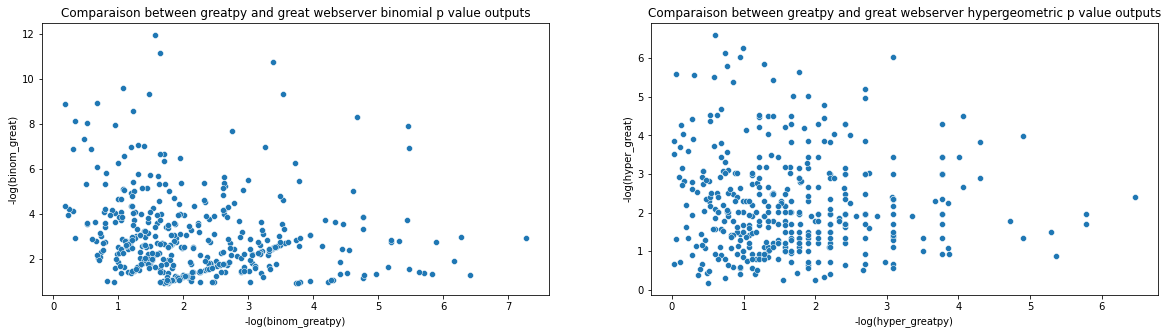

In [ ]:
fig,ax = plt.subplots(1,2,figsize = (20,5))
great.pl.scatterplot(binom,colname_x="binom_greatpy",colname_y="binom_great",ax=ax[0],title="Comparaison between greatpy and great webserver binomial p value outputs")
great.pl.scatterplot(hyper,colname_x="hyper_greatpy",colname_y="hyper_great",ax=ax[1],title="Comparaison between greatpy and great webserver hypergeometric p value outputs")
plt.show()


#### II.2.c Statistics

In [ ]:
def stat(binom_great_list_list, hyper_great_listpy_list,binom_great_list,hyper_great_list) : 
    return pd.DataFrame({
        "binom": [cov(m = binom_great_list_list, y = binom_great_list)[0][1],pearsonr(binom_great_list_list,binom_great_list)[0]],
        "hyper":[cov(m = hyper_great_listpy_list, y = hyper_great_list)[0][1],pearsonr(hyper_great_listpy_list,hyper_great_list)[0]]},
        index=["correlation_coefficient","pearson"])

In [ ]:
stat(binom_greatpy, hyper_greatpy,binom_great,hyper_great)

,binom,hyper
correlation_coefficient,-4.18196e-03,1.07131e-03
pearson,-2.33984e-01,2.85191e-02


The result returned by greatpy is similar to the one obtained (pearson coefficient = 1) but the results have been reduced to select only the ids present in great_output and greatpy_output. 

On the other hand, the two variables (binomial probability and hypergeometric probability) do not seem to be correlated because the correlation coefficient is close to 0 

## III Compare p values between binomial and hypergeometric tests 

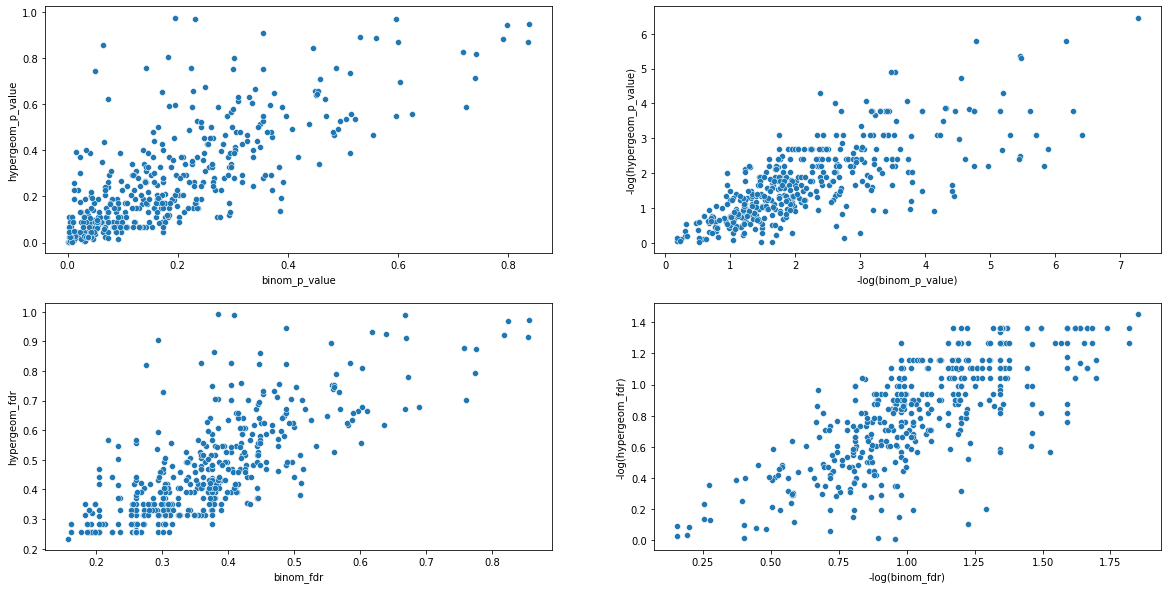

In [ ]:
fig,ax = plt.subplots(2,2,figsize=(20,10))
great.pl.scatterplot(
    enrichment,
    "binom_p_value",
    "hypergeom_p_value",
    minus_log10=False,ax=ax[0,0])
great.pl.scatterplot(
    enrichment,
    "binom_p_value",
    "hypergeom_p_value",
    minus_log10=True,ax=ax[0,1])
great.pl.scatterplot(
    enrichment,
    "binom_fdr",
    "hypergeom_fdr",
    minus_log10=False,ax=ax[1,0])
great.pl.scatterplot(
    enrichment,
    "binom_fdr",
    "hypergeom_fdr",
    minus_log10=True,ax=ax[1,1])
plt.show()

Resembling the images of the articule published by the Berjano lab: https://www.nature.com/articles/nbt.1630/figures/2

By default, GREAT ranks results by the binomial p-value, and we consider this the single best way to examine genome-wide cis-regulatory datasets. It accounts for biases in gene regulatory domain size and provides an accurate picture of the cis-regulatory landscape. (https://great-help.atlassian.net/wiki/spaces/GREAT/pages/655456/Statistics) 

In [ ]:
pd.DataFrame({
        "binom_vs_hyper": [cov(m = list(enrichment["binom_p_value"]), y = list(enrichment["hypergeom_p_value"]))[0][1],pearsonr(list(enrichment["binom_p_value"]), list(enrichment["hypergeom_p_value"]))[0]],
        "binom_fdr_vs_hyper_fdr":[cov(m = list(enrichment["binom_fdr"]), y = list(enrichment["hypergeom_fdr"]))[0][1],pearsonr(list(enrichment["binom_fdr"]), list(enrichment["hypergeom_fdr"]))[0]]},
        index=["binom_vs_hyper","pearson"])

,binom_vs_hyper,binom_fdr_vs_hyper_fdr
binom_vs_hyper,2.69667e-02,1.52566e-02
pearson,7.55575e-01,7.56956e-01


The correlation between the binomial test and the hypergeometric test is quite close to that found by great. 

https://www.ncbi.nlm.nih.gov/core/lw/2.0/html/tileshop_pmc/tileshop_pmc_inline.html?title=Click%20on%20image%20to%20zoom&p=PMC3&id=4840234_nihms768381f2.jpg